 ## Weather in Szeged 2006-2016: 

Is there a relationship between humidity and temperature? 

What about between humidity and apparent temperature? 

Can you predict the apparent temperature given the humidity?

In [1]:
import os
import sys
import gc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import shap
import statsmodels.formula.api as sm
import warnings
warnings.filterwarnings("ignore")
from dateutil.parser import parse
import plotly.graph_objects as go
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('weatherHistory.csv')

In [3]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
#Извлечем год, месяц, день и час из колонки Formatted Date
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], format='%Y-%m-%d %H:%M:%S.%f %z', utc=True)
df['Year'] = df['Formatted Date'].dt.year
df['Month'] = df['Formatted Date'].dt.month
df['Day'] = df['Formatted Date'].dt.day
df['Hour'] = df['Formatted Date'].dt.hour

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [6]:
df['Precip Type'].isnull().sum()

517

Рассчитаем процентное соотношение отсутствующих данных по отношению ко всему датасету

In [11]:
print("%.2f" % (100 * df['Precip Type'].isnull().sum() / len(df)))

0.54


Мы видим, что у нас 517 отсутсвующих значений (0.54%) в колонке вида осадкой (Precip Type). 
Несмотря на то, что подобное количество является небольшим и его можно было бы удалить, попробуем проверить следующие предположения:
1) Это действительно отсутствующие значения, для которых можно попробовать определить значение rain/ snow в соотвествие с данными

2) Это признак того, что погода была ясная, и нужно заменить на no precip

Посмотрим, сколько уникальных значений в колонке Precip type

In [12]:
df['Precip Type'].unique()

array(['rain', 'snow', nan], dtype=object)

In [13]:
df[df['Precip Type'].isnull()]['Summary'].value_counts()

Mostly Cloudy    180
Clear            127
Partly Cloudy     98
Overcast          81
Foggy             31
Name: Summary, dtype: int64

Видим, что значениям nan в Precip type соответсует summary который во многих случаях может относиться к погоде без осадков
В связи с тем, что измерения проводились каждый день, можно предположить, что нулевые значения отвечают за ясные дни и их стоит заменить на no precip

In [14]:
df['Precip Type'] = df['Precip Type'].fillna('no precip')

In [15]:
df['Precip Type'].unique()

array(['rain', 'snow', 'no precip'], dtype=object)

Тем не менее далее мы видим четкое разделение для колонки Precip Type: для температуры выше нуля у нас всегда наблюдается дождь, в ином случае снего, поэтому мы можем заполнить отсутствующие значения snow для температуры <= 0 и rain для >=0, однако скорее всего nan значения являются днями без осадков, поэтому заменили их на no precip

<AxesSubplot:xlabel='Temperature (C)', ylabel='Humidity'>

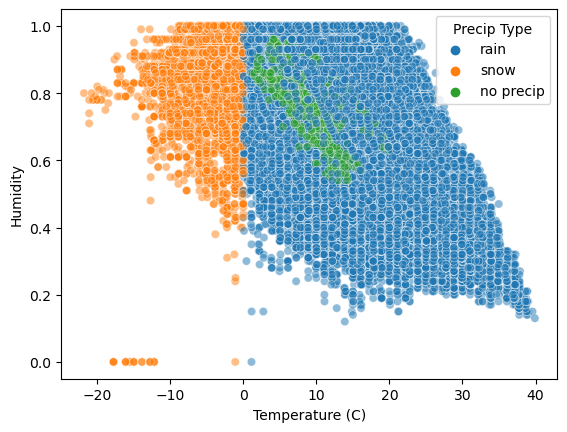

In [16]:
sns.scatterplot(data = df, y = 'Humidity', x = 'Temperature (C)', hue = 'Precip Type', alpha = 0.5)

Обращаем внимание на нулевые значения влажности (Humidity) в области сильно низкий температур. Согласно литературным данным наименьшие значения абсолютной влажности (до 0,1 г/м³) наблюдаются зимой на северо-востоке Сибири. Существуют данные, что в центральных районах Антарктиды в июле 1957 года абсолютная влажность понижалась до 0,001 г/м³."

Так как наши значения температур не опускаются ниже 20 С, и мы изучаем не северные широты, можно сделать вывод, что данные значения являются выпадающими, и их стоит удалить

In [17]:
df[df['Humidity'] == 0].count()

Formatted Date              22
Summary                     22
Precip Type                 22
Temperature (C)             22
Apparent Temperature (C)    22
Humidity                    22
Wind Speed (km/h)           22
Wind Bearing (degrees)      22
Visibility (km)             22
Loud Cover                  22
Pressure (millibars)        22
Daily Summary               22
Year                        22
Month                       22
Day                         22
Hour                        22
dtype: int64

In [18]:
df = df[df['Humidity'] > 0]
#удаляем выпадающие значения

In [19]:
#проверяем, что все удалили
df[df['Humidity'] == 0].shape[0]

0

In [20]:
df['Loud Cover'].unique()

array([0.])

Стоит обраить внимание на колонку Loud cover, которая состоит только из нулевых значений, в связи с чем её стоит удалить

In [21]:
df = df.drop('Loud Cover', axis = 1)

In [22]:
#перепроверяем, остались ли нулевые значения
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96431 entries, 0 to 96452
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96431 non-null  datetime64[ns, UTC]
 1   Summary                   96431 non-null  object             
 2   Precip Type               96431 non-null  object             
 3   Temperature (C)           96431 non-null  float64            
 4   Apparent Temperature (C)  96431 non-null  float64            
 5   Humidity                  96431 non-null  float64            
 6   Wind Speed (km/h)         96431 non-null  float64            
 7   Wind Bearing (degrees)    96431 non-null  float64            
 8   Visibility (km)           96431 non-null  float64            
 9   Pressure (millibars)      96431 non-null  float64            
 10  Daily Summary             96431 non-null  object             
 11  Year           

In [23]:
df['Summary'].nunique()

27

In [24]:
df['Daily Summary'].nunique()

214

Daily Summary в отличие от Summary имеет очень много уникальных описаний, которые, в виде дамми переменных, утяжелят модель машинного обучения, в связи с чем ее стоит удалить и ориентироваться только на Summary

In [25]:
df = df.drop('Daily Summary', axis = 1)

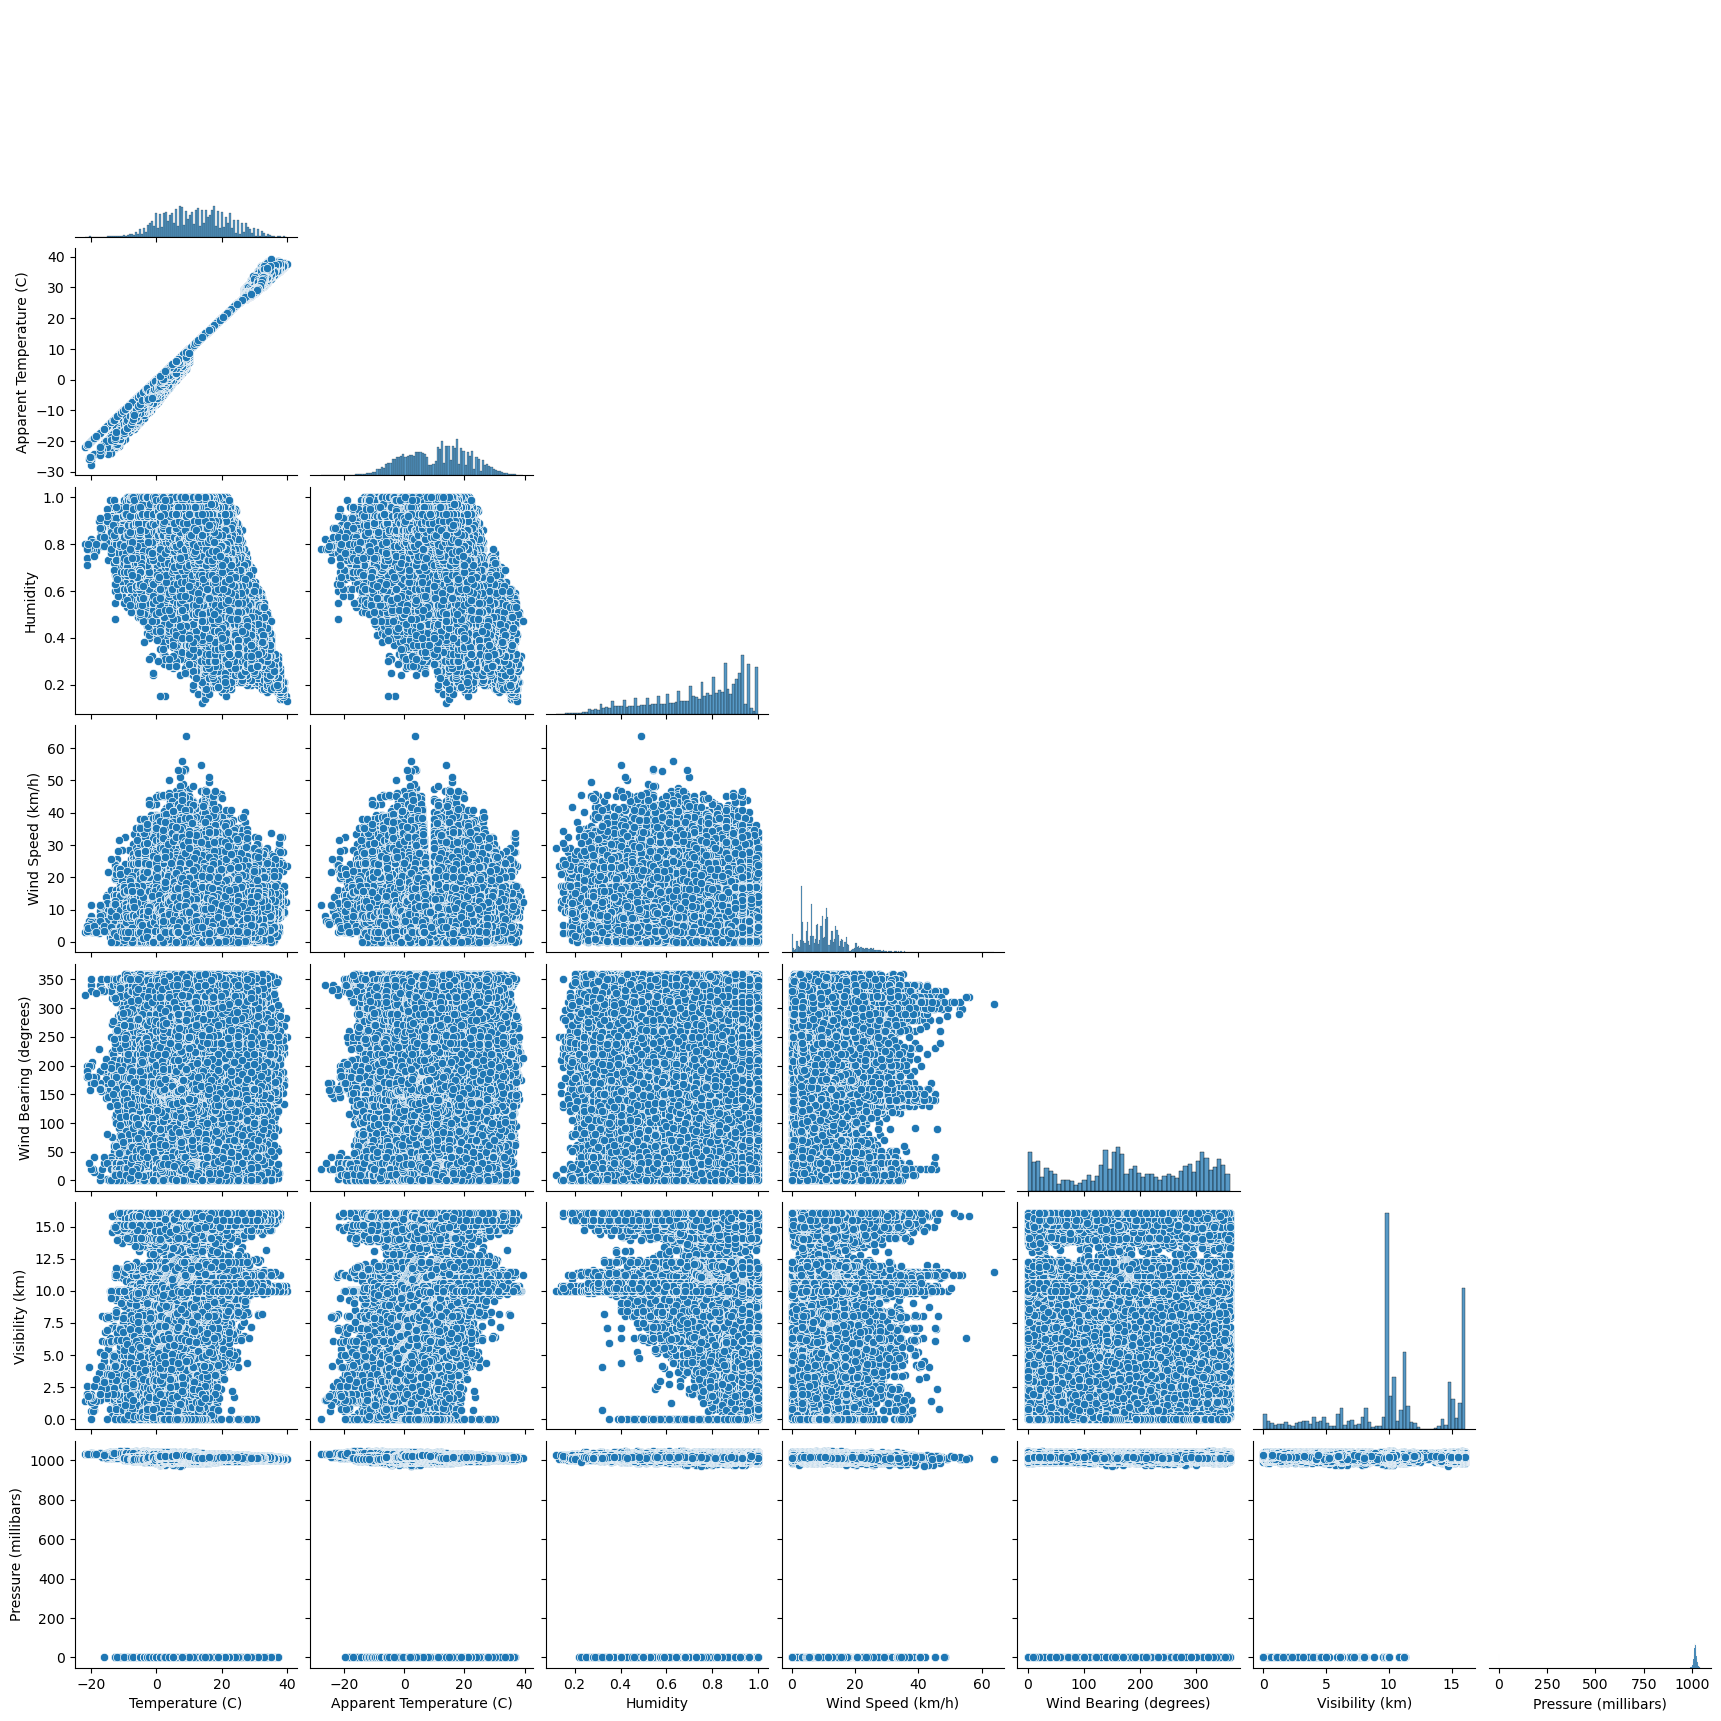

In [26]:
sns.pairplot(df[["Temperature (C)","Apparent Temperature (C)",
           "Humidity","Wind Speed (km/h)","Wind Bearing (degrees)",
           "Visibility (km)","Pressure (millibars)"]], corner = True);

Изучим тенденцию изменения влажности и температуры за 11 лет

In [27]:
df1 = df.set_index('Formatted Date')

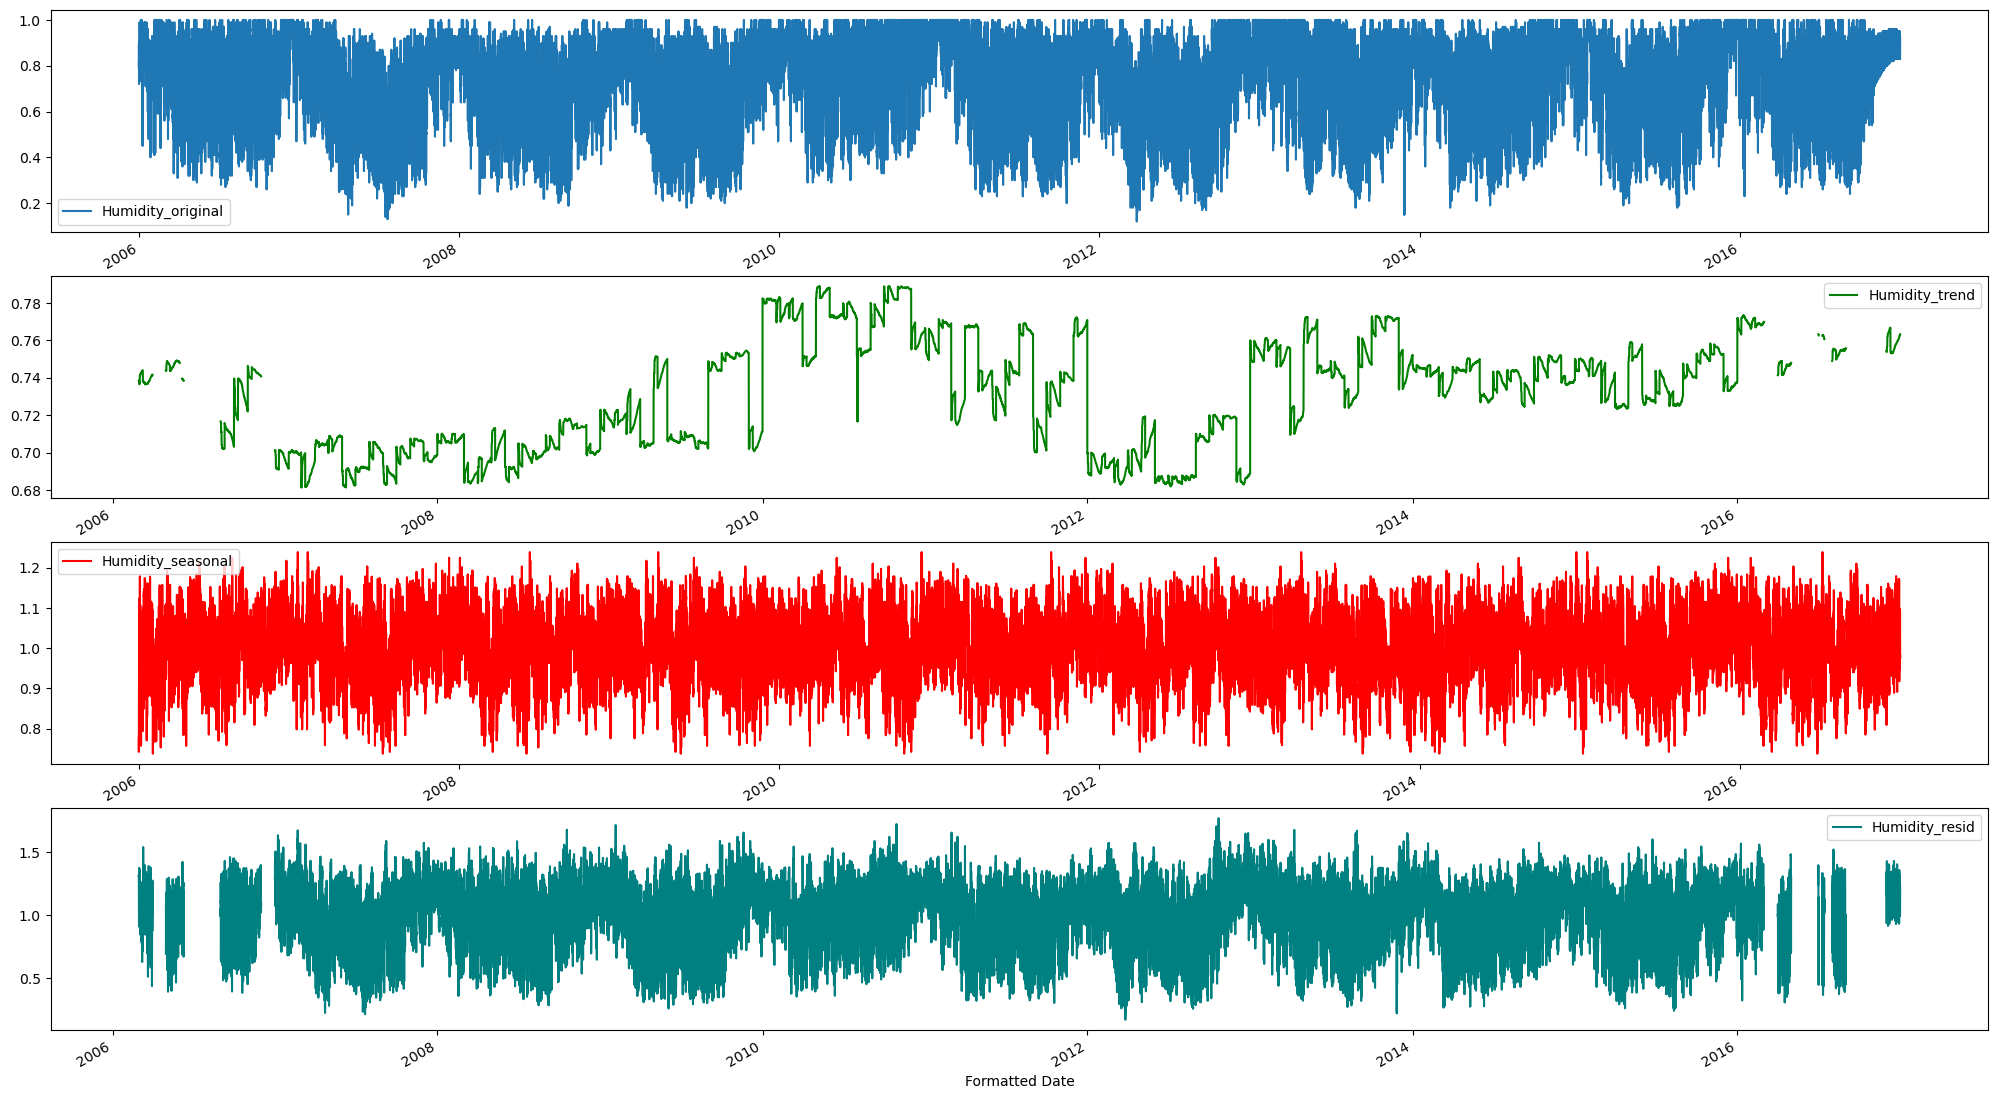

In [28]:
import statsmodels.api as sm
res = df1.copy().dropna()
res = sm.tsa.seasonal_decompose(res['Humidity'], model='multiplicative', period = 10000)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(25,15))
df1['Humidity'].plot(ax=ax1, legend=True)
res.trend.plot(ax=ax2, legend=True, color='g')
res.seasonal.plot(ax=ax3, legend=True, color='r')
res.resid.plot(ax=ax4, color='teal');
ax1.legend(['Humidity_original'])
ax2.legend(['Humidity_trend'])
ax3.legend(['Humidity_seasonal'])
ax4.legend(['Humidity_resid']);

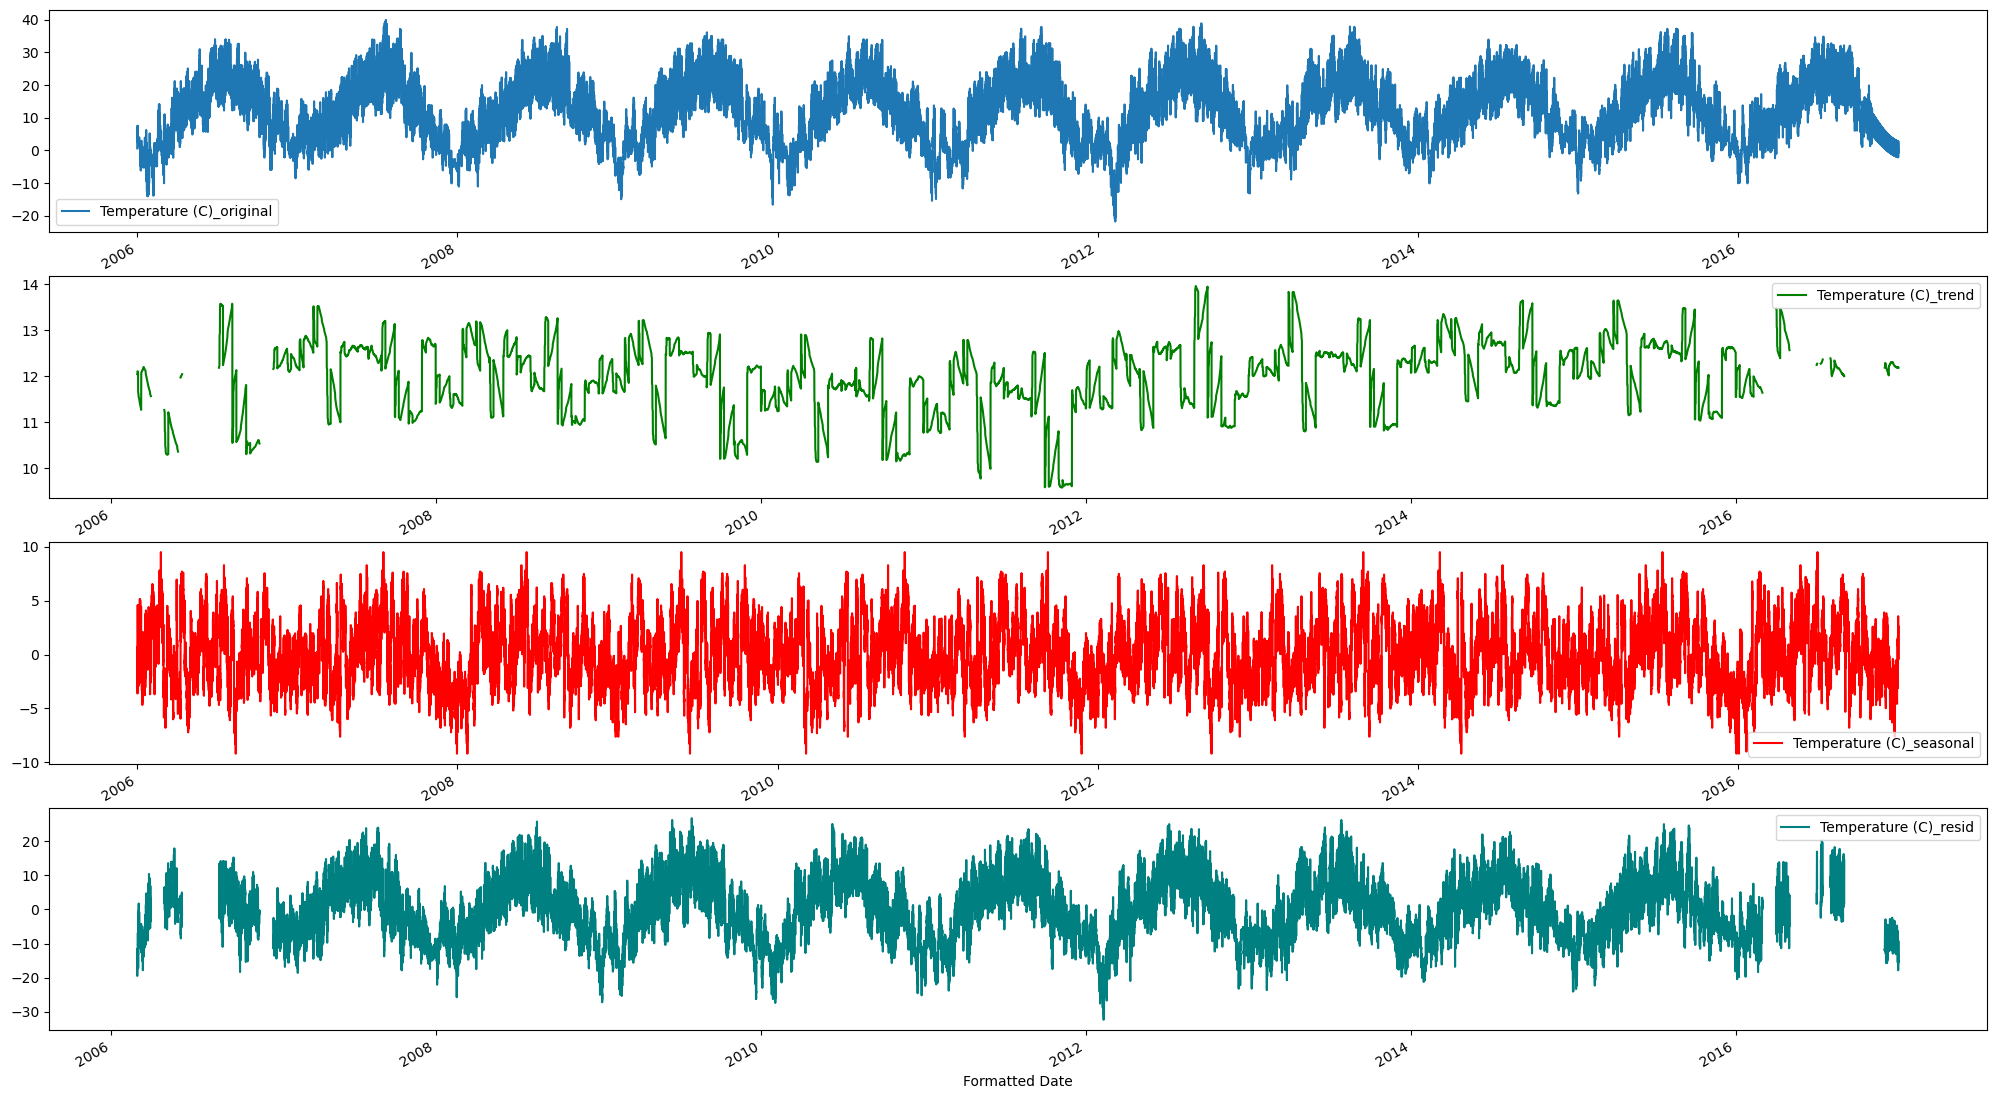

In [29]:
res = df1.copy().dropna()
res = sm.tsa.seasonal_decompose(res['Temperature (C)'], model='additive', period = 10000)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(25,15))
df1['Temperature (C)'].plot(ax=ax1, legend=True)
res.trend.plot(ax=ax2, legend=True, color='g')
res.seasonal.plot(ax=ax3, legend=True, color='r')
res.resid.plot(ax=ax4, color='teal');
ax1.legend(['Temperature (C)_original'])
ax2.legend(['Temperature (C)_trend'])
ax3.legend(['Temperature (C)_seasonal'])
ax4.legend(['Temperature (C)_resid']);

Сравнивая изменения влажности и температуры за 11 лет можем отметить:

- отсуствие тренда в обоих случаях
- сезонность присуща только для температуры
- мы не наблюдаем никакой закономерности в случайных колебаниях влажности, в то время как для температуры они совпадают с оригинальным графиком, что странно (?)

QQ (Quantile Quantile) Plot играет очень важную роль для графического анализа и сравнения двух вероятностных распределений путем построения квантилей друг против друга. Если два сравнимых распределения точно равны, то точки на графике QQ образуют идеальную прямую линию y=x.

Определеним с помощью данных графиков, являются ли данные распределения численных признаков нормальными. Для нас очень важно знать, являются ли наши данные нормальными или нет, чтобы применять различные статистические меры к данным и интерпретировать их в гораздо более понятной для человека визуализации.

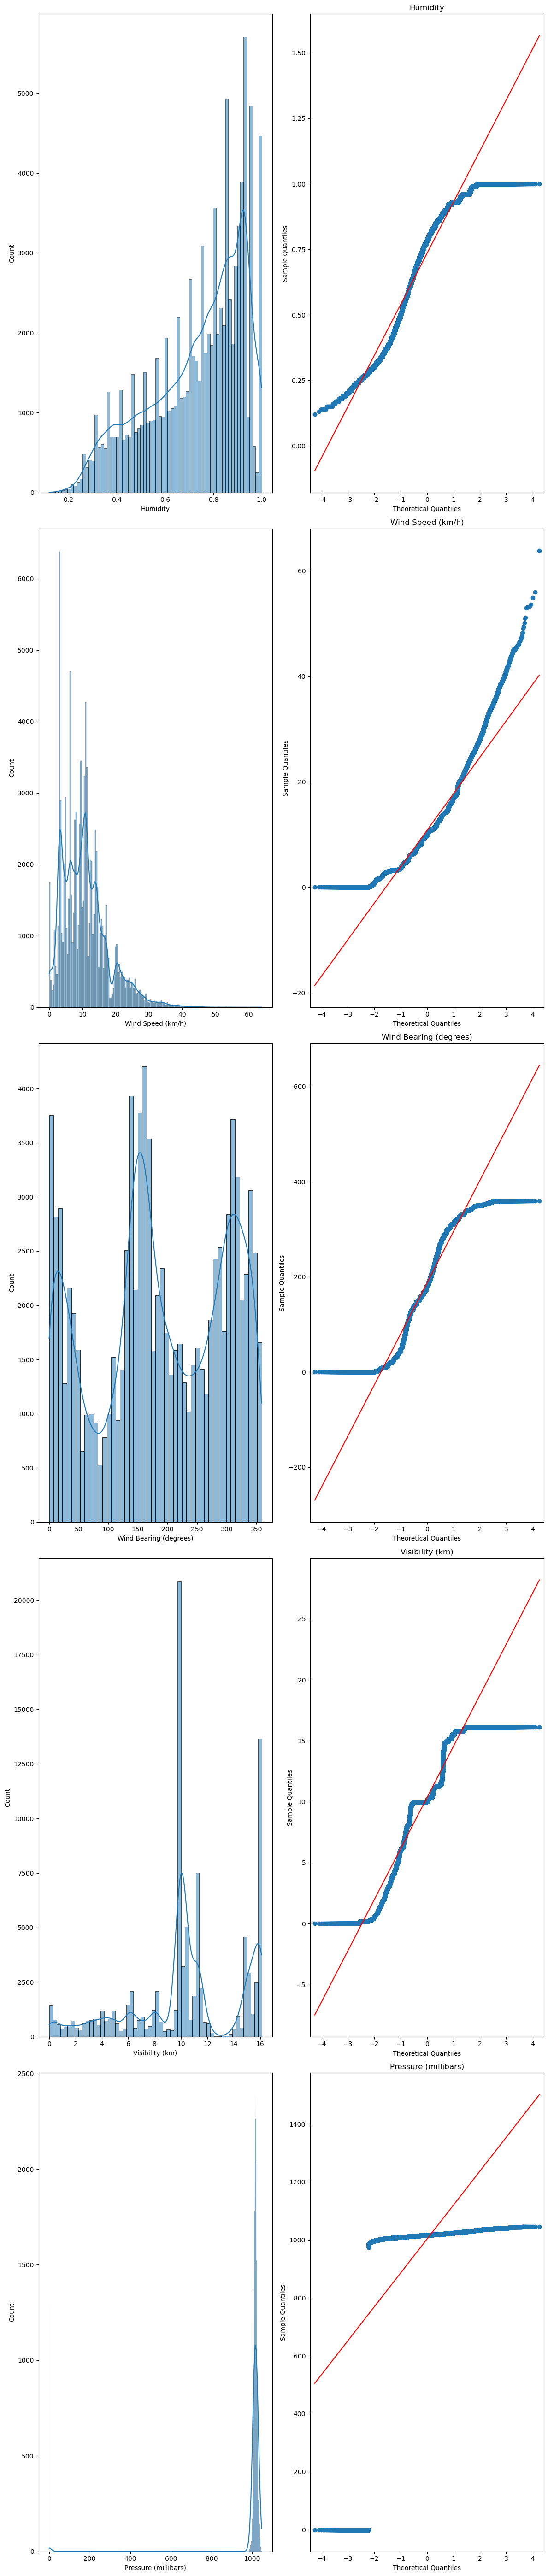

In [30]:
#Разделим признаки на категориальные и непрерывные
cat_col = ["Summary","Precip Type","Daily Summary"]
num_col = ["Humidity","Wind Speed (km/h)","Wind Bearing (degrees)",
           "Visibility (km)","Pressure (millibars)"]

#Построение графиков
fig,axes = plt.subplots(len(num_col),2,figsize=(12, len(df.columns)*4))
for i, col in enumerate(num_col):
    sns.histplot(df[col], ax = axes[i,0],kde =True)
    sm.qqplot(df[col].dropna(),line = "s",fmt = "b",ax = axes[i,1])
    axes[i, 1].set_title(col)

plt.tight_layout()
plt.show()

Если точки на концах кривой сильно разбросаны от прямой линии, то мы не можем утверждаем, что наши упорядоченные значения не имеют нормального распределения, и плохо подходят для моделей машинного обучения. Такую ситуацию мы наблюдаем для Humidity, Wind Speed, Wind Bearing (degrees), Visibility и Pressure.

При этом Temperature и Apparent Temperature демонстрируют нормальное распределение.

Подобное наблюдение позволяет понять, какой тип метода предварительной обработки следует применить к нашим данным, чтобы сделать их нормальными, для улучшения предсказаний модели машинного обучения.

In [31]:
df['Humidity'] = df['Humidity'] * 100
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,89.0,14.1197,251.0,15.8263,1015.13,2006,3,31,22
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,86.0,14.2646,259.0,15.8263,1015.63,2006,3,31,23
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,89.0,3.9284,204.0,14.9569,1015.94,2006,4,1,0
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,83.0,14.1036,269.0,15.8263,1016.41,2006,4,1,1
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,83.0,11.0446,259.0,15.8263,1016.51,2006,4,1,2


In [32]:
def scale_data(X):
    inv_sigmoid = lambda x: np.log(x / (1-x))
    
    X = X.copy()
    for col in num_col:
        X[col] = preprocessing.minmax_scale(X[col], feature_range=(0+1e-6, 1-1e-6))
        X[col] = X[col].apply(inv_sigmoid)
    X[num_col] = preprocessing.power_transform(X[num_col])
    #X['loudness'] = X['loudness'].apply(lambda x: np.log1p(-x))
    return X
df_scaled = scale_data(df)

Преобразовали данные, чтобы сделать распределение приближенным к нормальному

Проверим, что получилось

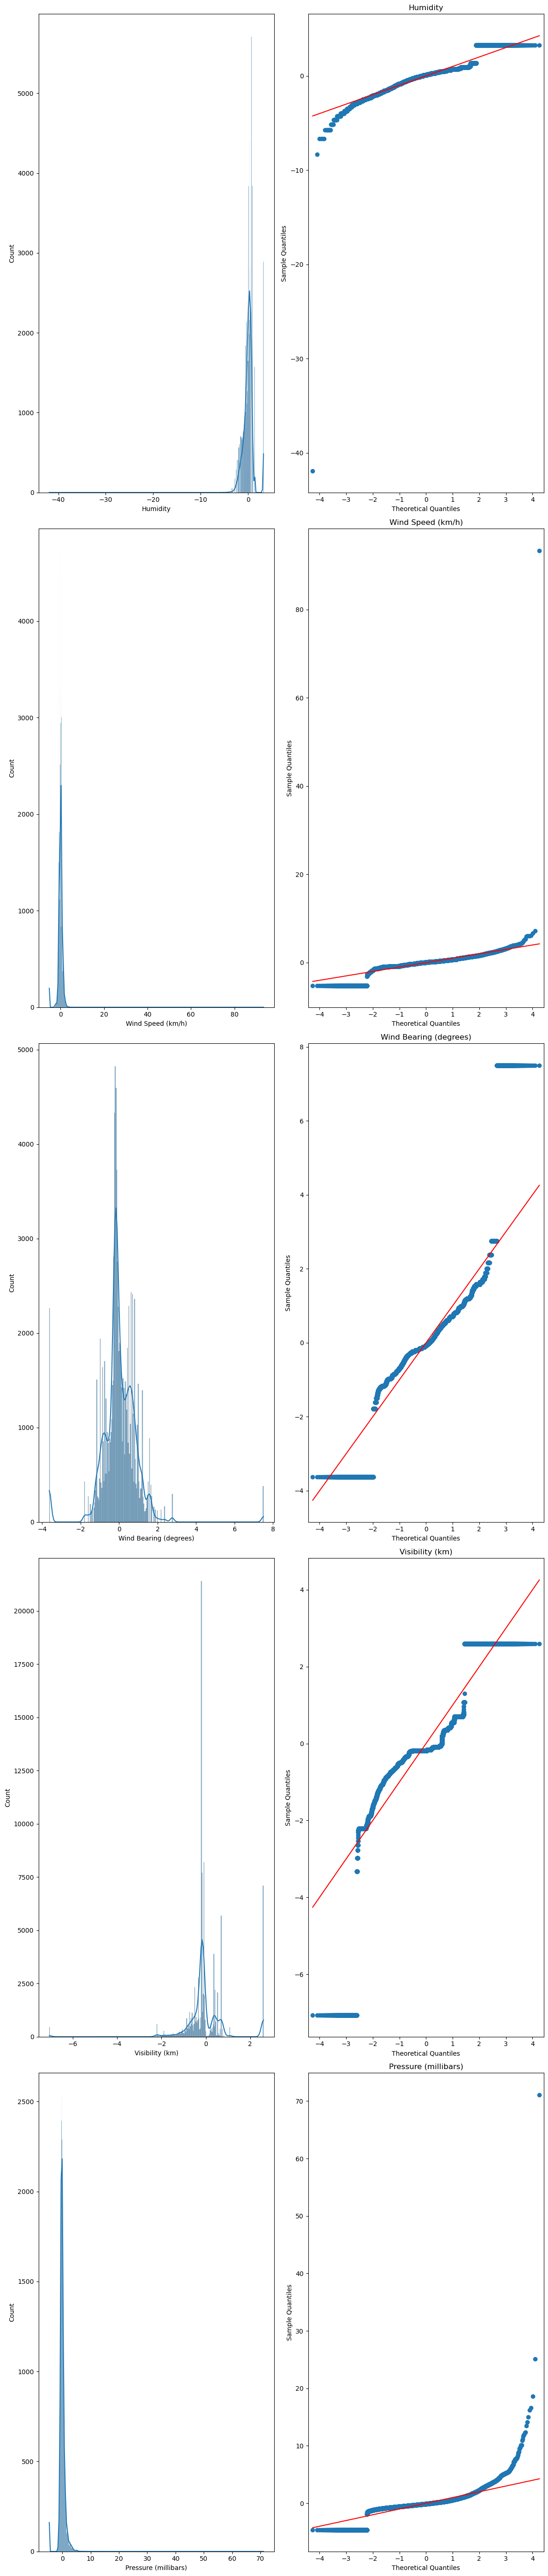

In [33]:
fig,axes = plt.subplots(len(num_col),2,figsize=(12, len(df.columns)*4))
for i, col in enumerate(num_col):
    sns.histplot(df_scaled[col], ax = axes[i,0],kde =True)
    sm.qqplot(df_scaled[col].dropna(),line = "s",fmt = "b",ax = axes[i,1])
    axes[i, 1].set_title(col)

plt.tight_layout()
plt.show()

## Напомним нашу задачу:

Is there a relationship between humidity and temperature?

What about between humidity and apparent temperature?

Can you predict the apparent temperature given the humidity?

#### Согласно последнему вопросу, в качестве целевой переменной мы выберем параметр Apparent Temperature

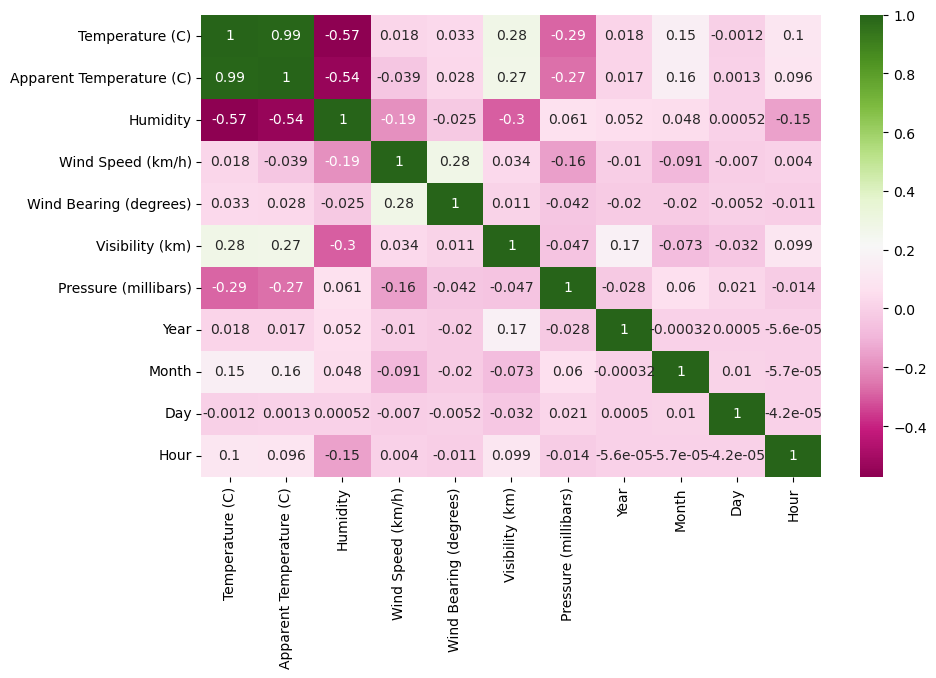

In [34]:
plt.figure(figsize = (10, 6))
sns.heatmap(df_scaled.corr(), annot = True, cmap = 'PiYG');

Обращаем внимание, что Apparent Temperature и Temperature имеют сильную взаимную корреляцию, которая может привести к переобученности модели. Так как наша задача состоит в предсказании Apparent Temperature, далее мы удалим Temperature

In [35]:
df_scaled = df_scaled.drop(['Temperature (C)'], axis = 1)

In [36]:
import statsmodels.formula.api as sm
mod=sm.ols(formula='df["Apparent Temperature (C)"]~df["Humidity"]',data=df)
res=mod.fit()
print(res.summary())

                                  OLS Regression Results                                  
Dep. Variable:     df["Apparent Temperature (C)"]   R-squared:                       0.368
Model:                                        OLS   Adj. R-squared:                  0.368
Method:                             Least Squares   F-statistic:                 5.606e+04
Date:                            Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                                    15:32:43   Log-Likelihood:            -3.4320e+05
No. Observations:                           96431   AIC:                         6.864e+05
Df Residuals:                               96429   BIC:                         6.864e+05
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------

## Линейная регрессия

In [37]:
fin_df = df_scaled.drop(['Formatted Date'], axis = 1)
df_nums = fin_df.select_dtypes(exclude='object')
df_objs = fin_df.select_dtypes(include='object')
df_objs = pd.get_dummies(df_objs,drop_first=True)
final_df = pd.concat([df_nums,df_objs],axis=1)
final_df

,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour,...,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_rain,Precip Type_snow
0,7.388889,0.490756,0.464550,0.260767,0.702013,-0.200622,2006,3,31,22,...,1,0,0,0,0,0,0,0,1,0
1,7.227778,0.367590,0.477261,0.306631,0.702013,-0.163516,2006,3,31,23,...,1,0,0,0,0,0,0,0,1,0
2,9.377778,0.490756,-0.719794,0.029541,0.358307,-0.140115,2006,4,1,0,...,0,0,0,0,0,0,0,0,1,0
3,5.944444,0.257835,0.463135,0.368058,0.702013,-0.104040,2006,4,1,1,...,1,0,0,0,0,0,0,0,1,0
4,6.977778,0.257835,0.181814,0.306631,0.702013,-0.096269,2006,4,1,2,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,26.016667,-1.228484,0.177120,-0.836602,2.601403,-0.256280,2016,9,9,17,...,1,0,0,0,0,0,0,0,1,0
96449,24.583333,-0.967979,0.087599,-0.972384,0.540901,-0.198417,2016,9,9,18,...,1,0,0,0,0,0,0,0,1,0
96450,22.038889,-0.624655,-0.028565,-0.847055,2.601403,-0.161265,2016,9,9,19,...,1,0,0,0,0,0,0,0,1,0
96451,21.522222,-0.479508,0.131232,-0.972384,2.601403,-0.139355,2016,9,9,20,...,1,0,0,0,0,0,0,0,1,0


In [38]:
X = final_df.drop(('Apparent Temperature (C)'),axis=1)

y = final_df['Apparent Temperature (C)']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [40]:
scaler = StandardScaler()

In [41]:
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [42]:
model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                    eps= 0.01,
                    n_alphas=100,
                    max_iter=1000000)

In [43]:
model.fit(X_train_sc,y_train)

ElasticNetCV(eps=0.01, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [44]:
print(f' Best l1_ratio: {model.l1_ratio_}')
print(f' Best alpha: {model.alpha_}')

 Best l1_ratio: 1.0
 Best alpha: 0.06005778218389988


Видим, что модель учитывает только Lasso регуляризацию 

In [45]:
test_predictions = model.predict(X_test_sc)

In [46]:
m = round(df['Apparent Temperature (C)'].mean(), 2)
print(f'Mean Apparent Temperature (C): {m}')
print(f'MAE: {mean_absolute_error(y_test,test_predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,test_predictions))}')


Mean Apparent Temperature (C): 10.86
MAE: 5.6413004001895075
RMSE: 6.928032891974248


In [47]:
y_train_pred=model.predict(X_train_sc)

In [48]:
print(f'Train error: {round(r2_score(y_train, y_train_pred), 2)}')
print(f'Test error: {round(r2_score(y_test, test_predictions), 2)}')

Train error: 0.58
Test error: 0.58


Наша модель предсказывает значения с ошибкой в 51,93%, а коэффициент детерминации составляет 0,58.

Значения оценки работы модели MAE и RMSE не отличаются друг от друга, что говорит об отсутвии точек, для которых модель ошибается

## Визуализация

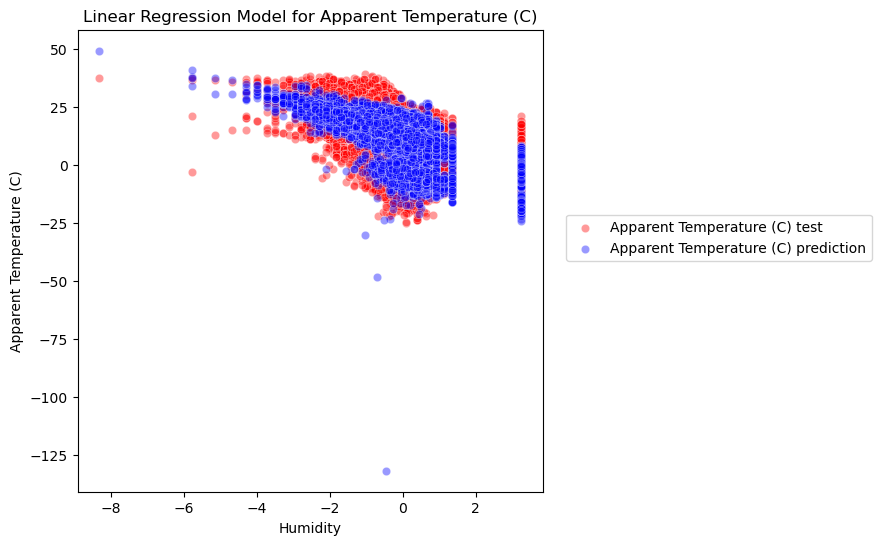

In [45]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test['Humidity'], y = y_test, color='red', alpha=0.4)
sns.scatterplot(x = X_test['Humidity'], y = test_predictions, color='blue', alpha=0.4)
plt.xlabel('Humidity')
plt.ylabel('Apparent Temperature (C)')
plt.title('Linear Regression Model for Apparent Temperature (C)')
plt.legend(['Apparent Temperature (C) test', 'Apparent Temperature (C) prediction'], loc = (1.05, 0.5));

Так как у нас предварительно было проведено масштабирование, расмматриваемые значения влажности и температуры отличаются от исходных

In [49]:
model.coef_

array([-4.60227077e+00, -1.77964075e+00,  4.09990336e-01,  4.58223320e-01,
       -1.77806040e+00,  6.70303567e-02,  1.20545835e+00,  3.45271449e-02,
        2.31062325e-02,  0.00000000e+00, -2.80040079e-03, -6.34581677e-02,
       -2.47231160e-01, -6.09444025e-02, -3.66979616e-02,  5.20446804e-01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.85342304e-02,  1.48867688e-01,  3.10775160e-02,  9.32564910e-02,
       -0.00000000e+00,  0.00000000e+00, -6.41871811e-01,  8.79683258e-01,
        0.00000000e+00, -8.18798931e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.10756831e-02, -4.03378237e-03,  5.28951682e-01,
       -3.60573934e+00])

  0%|          | 0/28930 [00:00<?, ?it/s]

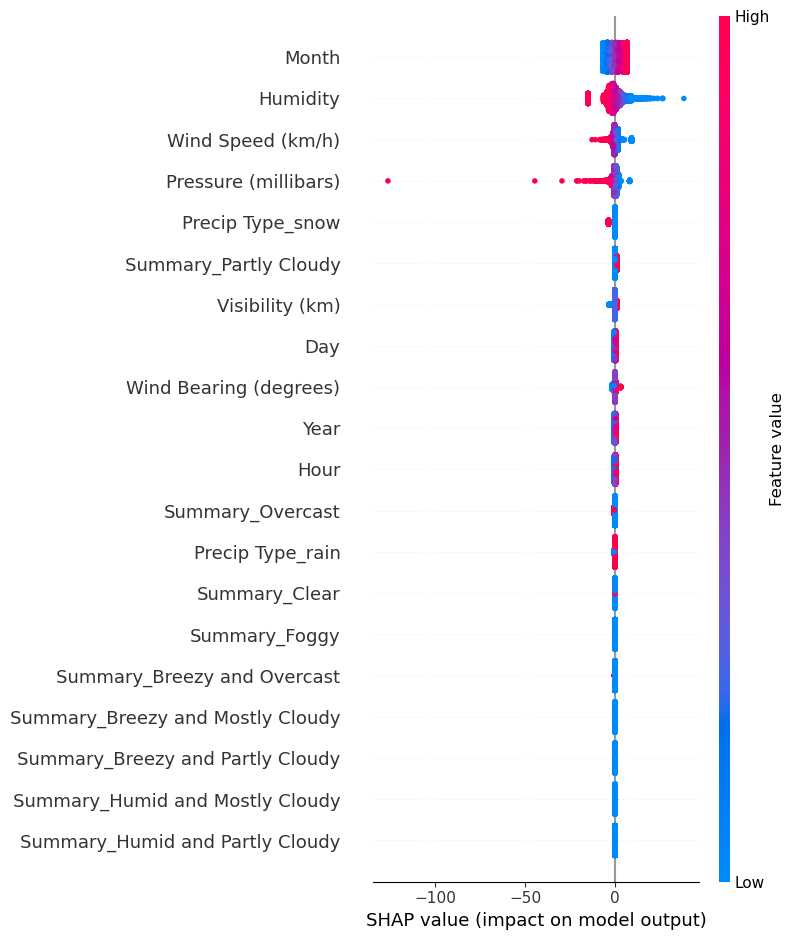

In [50]:
X_train_summary = shap.kmeans(X_train, 10)
ex = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Из данного графика мы видим, что наиболее влиятельными признаками являются месяц, влажность, давление и скорость ветра. Категориальные же признакие, такие как общая погода за день, не влияет на определение температуры.